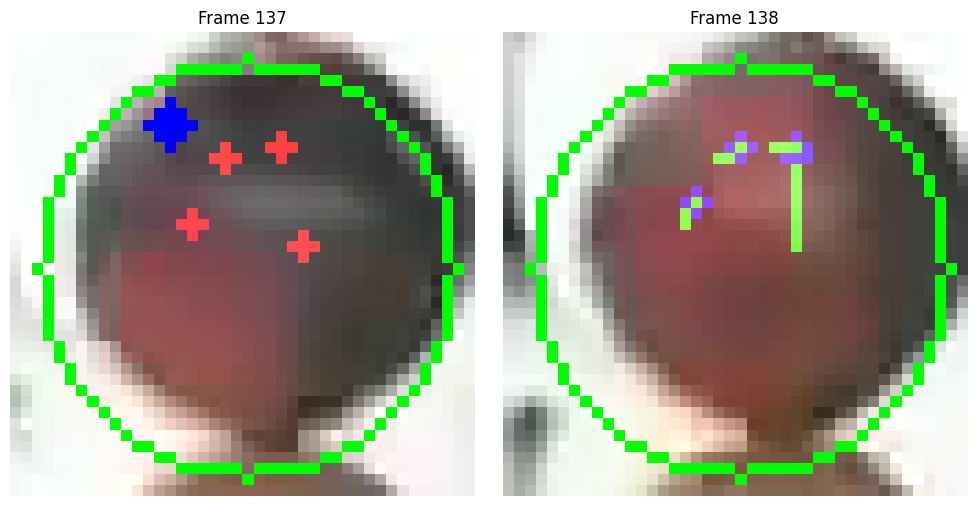

<Figure size 640x480 with 0 Axes>

Failed to read frame 155.
Failed to read frame 155.
Failed to read frame 156.
Failed to read frame 157.
Failed to read frame 158.
Failed to read frame 159.
Failed to read frame 160.
Failed to read frame 161.
Failed to read frame 162.
Failed to read frame 163.
Failed to read frame 164.
Failed to read frame 165.
Failed to read frame 166.
Failed to read frame 167.
Failed to read frame 168.
Failed to read frame 169.
Failed to read frame 170.
Failed to read frame 171.
Failed to read frame 172.
Failed to read frame 173.
Failed to read frame 174.
Failed to read frame 175.
Failed to read frame 176.
Failed to read frame 177.
Failed to read frame 178.
Failed to read frame 179.
Failed to read frame 180.
Failed to read frame 181.
Failed to read frame 182.
Failed to read frame 183.
Failed to read frame 184.
Failed to read frame 185.
Failed to read frame 186.
Failed to read frame 187.
Failed to read frame 188.
Failed to read frame 189.
Failed to read frame 190.
Failed to read frame 191.
Failed to re

In [29]:
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import time
from IPython.display import clear_output, display
import math

# --- Configurations ---
VIDEO_NUMBER = "5"
PROJECT_ROOT = Path().resolve().parent.parent
INPUT_VIDEO_PATH = str(PROJECT_ROOT / "data" / f"recording_{VIDEO_NUMBER}" / f"Recording_{VIDEO_NUMBER}.mp4")
INPUT_CSV_PATH = str(PROJECT_ROOT / "data" / "auxiliary_data" / "circle_positions" / f"Adjusted_positions_new_{VIDEO_NUMBER}.csv")

# --- Load video and CSV ---
cap = cv2.VideoCapture(INPUT_VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)

if not cap.isOpened():
    raise IOError("Error: Could not open video.")
 
df = pd.read_csv(INPUT_CSV_PATH)
if df.empty:
    raise ValueError("Error: The CSV file is empty.")

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
offset = 2
output_data = []


# --- Process frame pairs ---
for frame_number in range(frame_count - 1):

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame1 = cap.read()
    if not ret:
        print(f"Failed to read frame {frame_number}.")
        continue

    ret, frame2 = cap.read()
    if not ret:
        print(f"Failed to read frame {frame_number + 1}.")
        continue

    # --- Get CSV data for current frame pair ---
    try:
        df_row1 = df.iloc[frame_number]
        df_row2 = df.iloc[frame_number + 1]

        if df_row1[['x', 'y', 'radius']].isnull().any() or df_row2[['x', 'y', 'radius']].isnull().any():
            continue
    except IndexError:
        print(f"No CSV data for frame {frame_number}.")
        continue

    # --- Compute ball centers and ROI bounds ---
    ball_center1 = np.array([int(df_row1['x']), int(df_row1['y'])])
    ball_center2 = np.array([int(df_row2['x']), int(df_row2['y'])])
    ball_radius = int(df_row1['radius'])

    def roi_bounds(center, radius, frame_shape):
        x_min = max(center[0] - radius - offset, 0)
        x_max = min(center[0] + radius + offset, frame_shape[1])
        y_min = max(center[1] - radius - offset, 0)
        y_max = min(center[1] + radius + offset, frame_shape[0])
        return x_min, x_max, y_min, y_max

    x_min1, x_max1, y_min1, y_max1 = roi_bounds(ball_center1, ball_radius, frame1.shape)
    x_min2, x_max2, y_min2, y_max2 = roi_bounds(ball_center2, ball_radius, frame2.shape)

    roi1 = frame1[y_min1:y_max1, x_min1:x_max1]
    roi2 = frame2[y_min2:y_max2, x_min2:x_max2]
    gray1 = cv2.cvtColor(roi1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(roi2, cv2.COLOR_BGR2GRAY)

    center_roi1 = ball_center1 - [x_min1, y_min1]
    center_roi2 = ball_center2 - [x_min2, y_min2]

    # --- Mask for feature detection ---
    mask = np.zeros_like(gray1)
    cv2.circle(mask, tuple(center_roi1.astype(int)), int(ball_radius * 0.8), 255, -1)

    feature_params = dict(
        maxCorners=100,
        qualityLevel=0.001,
        minDistance=0,
        blockSize=3
    )

    p0 = cv2.goodFeaturesToTrack(gray1, mask=mask, **feature_params)
    if p0 is None:
        raise ValueError("No features detected. Try relaxing parameters.")

    # --- Optical flow tracking (forward + backward for validation) ---
    lk_params = dict(
        winSize=(21, 21), maxLevel=3,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 15, 0.01)
    )

    # Forward tracking
    p1, status_forward, _ = cv2.calcOpticalFlowPyrLK(gray1, gray2, p0, None, **lk_params)
    # Backward tracking
    p0r, status_backward, _ = cv2.calcOpticalFlowPyrLK(gray2, gray1, p1, None, **lk_params)

    # Calculate forward-backward error
    fb_error = np.linalg.norm(p0 - p0r, axis=2)

    # Filtering criteria
    fb_threshold = 10.0  # Pixel threshold for forward-backward error
    movement_threshold = ball_radius  # Reject points moving too far (could be tuned)
    low_movement_threshold = ball_radius/3  # Reject points with moving too little
    
    good_pts = []
    old3d, new3d = [], []

    for i, (old_pt, new_pt, back_pt, s1, s2, err) in enumerate(zip(
        p0.reshape(-1, 2), p1.reshape(-1, 2), p0r.reshape(-1, 2),
        status_forward.ravel(), status_backward.ravel(), fb_error.ravel()
    )):
        if s1 and s2 and err < fb_threshold:
            displacement = np.linalg.norm(new_pt - old_pt)
            if displacement < movement_threshold and displacement > low_movement_threshold:
                ox, oy = old_pt - center_roi1
                nx, ny = new_pt - center_roi2
                oz = np.sqrt(max(ball_radius**2 - ox**2 - oy**2, 0))
                nz = np.sqrt(max(ball_radius**2 - nx**2 - ny**2, 0))
                old3d.append([ox, oy, oz])
                new3d.append([nx, ny, nz])
                good_pts.append((old_pt, new_pt))  # Save for visualization


    # --- At this point, old3d and new3d are already filtered; just convert them to arrays ---
    old3d = np.array(old3d)
    new3d = np.array(new3d)

    if old3d.shape[0] < 3:
        low_movement_threshold = ball_radius/10  # Reject points with moving too little
    
        good_pts = []
        old3d, new3d = [], []

        for i, (old_pt, new_pt, back_pt, s1, s2, err) in enumerate(zip(
            p0.reshape(-1, 2), p1.reshape(-1, 2), p0r.reshape(-1, 2),
            status_forward.ravel(), status_backward.ravel(), fb_error.ravel()
        )):
            if s1 and s2 and err < fb_threshold:
                displacement = np.linalg.norm(new_pt - old_pt)
                if displacement < movement_threshold and displacement > low_movement_threshold:
                    ox, oy = old_pt - center_roi1
                    nx, ny = new_pt - center_roi2
                    oz = np.sqrt(max(ball_radius**2 - ox**2 - oy**2, 0))
                    nz = np.sqrt(max(ball_radius**2 - nx**2 - ny**2, 0))
                    old3d.append([ox, oy, oz])
                    new3d.append([nx, ny, nz])
                    good_pts.append((old_pt, new_pt))  # Save for visualization


        # --- At this point, old3d and new3d are already filtered; just convert them to arrays ---
        old3d = np.array(old3d)
        new3d = np.array(new3d)

    if old3d.shape[0] < 3:
        print(f"Frame {frame_number}: only {old3d.shape[0]} points after filtering, skipping rotation")
        continue

    # --- Kabsch algorithm for rotation ---
    P = old3d #- old3d.mean(axis=0)
    Q = new3d #- new3d.mean(axis=0)
    H = P.T @ Q
    U, _, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    cos_theta = (np.trace(R) - 1) / 2
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    theta = np.arccos(cos_theta)
    if np.isclose(theta, 0):
        axis = np.array([0.0, 0.0, 1.0])  # default/fallback axis
    else:
        axis = np.array([R[2,1] - R[1,2], R[0,2] - R[2,0], R[1,0] - R[0,1]]) / (2 * np.sin(theta))
        axis /= np.linalg.norm(axis)
    print(f"Rotation matrix:\n{R}")
    print(f"θ = {theta:.3f} rad, which is {theta*180/np.pi:.1f}°")

    # Save data for output
    output_data.append({
        "frame": int(df_row1['frame']),
        "x": df_row1['x'],
        "y": df_row1['y'],
        "radius": df_row1['radius'],
        "x_axis": axis[0],
        "y_axis": axis[1],
        "z_axis": axis[2],
        "angle": theta  # in radians; multiply by 180/np.pi if degrees preferred
    })

    # --- Compute rotation poles ---
    pole3d = axis * ball_radius
    opp_pole3d = -pole3d

    pole2d = center_roi1[:2] - pole3d[:2]
    opp_pole2d = center_roi1[:2] - opp_pole3d[:2]

    # --- Visualization overlay ---
    mask = np.zeros_like(roi1)
    mask2 = np.zeros_like(roi2)

    for old_pt, new_pt in good_pts:
        c = tuple(old_pt.astype(int))
        a = tuple(new_pt.astype(int))
        cv2.circle(mask, c, 1, (0, 0, 255), -1)
        cv2.circle(mask2, a, 1, (255, 0, 0), -1)
        cv2.line(mask2, c, a, (0, 255, 0), 1)

    output_roi1 = cv2.addWeighted(roi1, 1, mask, 1, 0)
    output_rgb1 = cv2.cvtColor(output_roi1, cv2.COLOR_BGR2RGB)

    output_roi2 = cv2.addWeighted(roi2, 1, mask2, 1, 0)
    output_rgb2 = cv2.cvtColor(output_roi2, cv2.COLOR_BGR2RGB)

    cv2.circle(output_rgb1, tuple(center_roi1), ball_radius, (0, 255, 0), 1)
    cv2.circle(output_rgb2, tuple(center_roi2), ball_radius, (0, 255, 0), 1)

    cv2.circle(output_rgb1, tuple(pole2d.astype(int)), 2, (0, 0, 255), -1)
    #cv2.circle(output_rgb1, tuple(opp_pole2d.astype(int)), 2, (0, 0, 255), -1)

    print(f"Frame {frame_number}: {len(good_pts)} points used")

    # --- Display results ---
    clear_output(wait=True)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(output_rgb1)
    axes[0].axis('off')
    axes[0].set_title(f'Frame {frame_number}')
    axes[1].imshow(output_rgb2)
    axes[1].axis('off')
    axes[1].set_title(f'Frame {frame_number + 1}')
    plt.tight_layout()
    plt.show()
    display(plt.gcf())
    plt.close()
    time.sleep(1 / fps)

output_df = pd.DataFrame(output_data)
OUTPUT_CSV_PATH = str(PROJECT_ROOT / "notebook" / "spin" / "intermediate_data" / f"Rotation_data_TEST1_{VIDEO_NUMBER}.csv")
output_df.to_csv(OUTPUT_CSV_PATH, index=False)
print(f"Saved rotation data to {OUTPUT_CSV_PATH}") 